# Proces Hawkesa

## Wstęp

Procesy punktowe są kolekcją losowych punktów rozmieszczonych w pewnej przestrzeni (np. czas). Jednym z najprostszych procesów punktowych jest proces Poissona. Jego główną cechą jest brak pamięci, co oznacza, że zaobserwowane zdarzenia z przeszłości nie wpływają na przyszłe zdarzenia. Obserwując otaczający nas rzeczywistość, możemy zauważyć, że zdarzenia bardzo często wpływają na siebie, przez co bezpamięciowy proces Poissona jest zbyt dużym uproszczeniem. Chcąc zamodelować np. rozprzestrzenianie się posta w mediach społecznościowych musimy wziąć pod uwagę popularność informacji, która będzie rosła wraz z jego częstym udostępnianiem, a także fakt, że wraz z upływem czasu ta popularność zacznie zanikać. Idealnym narzędziem w tego typu problemach jest proces Hawkesa.

## Definicja procesu Hawkesa
Proces Hawkesa jest to proces punktowy zdefiniowany przez warunkową funkcję intensywności $\lambda(t|\mathcal{H_t})$, która zależy od wszystkich przeszłych zdarzeń $\mathcal{H_t}$. Pojawienie się nowego zdarzenia powoduje wzrost funkcji intensywności, a tym samym zwiększenie prawdopodobieństwa wystąpienia kolejnego zdarzenia. Jest to najważniejsza cecha procesu Hawkesa określana jako samo ekscytacja zdarzeń (`self-exctinig`). Dodatkowo funkcja intensywności maleje z czasem, tym samym zmniejszając wpływ starszych zdarzeń.

Funkcja intensywności przyjmuje formę:

$$ \lambda(t|\mathcal{H_t})=\lambda_0(t)+\sum_{i:t>T_i}\phi(t-T_i)$$

gdzie $T_i>t$ oznacza wszystkie zdarzenia zaobserwowane przed aktualnym czasem $t$, które mają wpływ na aktualną wartość funkcji intensywności w chwili $t$. $\lambda_0$ jest funkcją intensywności bazowej, która odpowiada za losowe pojawianie się zdarzeń wywołanych przez zewnętrzne czynniki. $\phi$ jest nazywane funkcją kernela, która determinuje wpływ zdarzenia $T_i$ na aktualną wartość intensywności.  czasu.

## Kernele
Używając procesu Hawkesa do modelowania strumienia zdarzeń ważne jest, aby wybrać kernel, który najlepiej opisuje dla naszych danych malejący wraz z czasem wpływ zdarzeń na funkcję intensywności. Dwie najczęściej używane kernele to:
- funkcja eksponencjalna: $\phi_{EXP}(t) = \kappa \theta e^{-\theta t}$
- funkcja potęgowa: $\phi_{PL}(t) = \kappa (t + c)^{-(1+\theta)}$

## Instalacja evently
Do pracy z procesem Hawkesa będziemy wykorzystywali pakiet [evently](https://github.com/behavioral-ds/evently), który w prosty sposób pozwala na symulację i dopasowanie procesu Hawkesa z różnymi funkcjami kernela. 

Przed przystąpieniem do instalacji pakietu należy zainstalować [R](https://cran.r-project.org) i [RStudio](https://www.rstudio.com).

Evently instalujemy wykonując następujące komendy w RStudio:

In [ ]:
if (!require('devtools')) install.packages('devtools')
devtools::install_github('behavioral-ds/evently')

Powyższy kod zainstaluje dodatkowe zależności wymagane do działania evently (poweRlaw, AMPL, Ipopt).

## Symulacja sekwencji zdarzeń
Proces Hawkesa jest modelem generatywnym, który pozwala dla zadanych parametrów zasymulować serię zdarzeń. W tym celu używa się algorytmu przerzedzania (`thinning algorithm`), który opiera się na zastosowaniu `rejection sampling`. Głównym zadaniem algorytmu jest symulacja czasu między kolejnymi zdarzeniami zgodnie z funkcją intensywności $\lambda$.

In [13]:
library(evently)

set.seed(13)

init_par <- c(K = 0.9, theta = 1)

# Generowanie zupełnie nowej serii zdarzeń
data <- generate_series(par = init_par, model_type = c('EXP'), Tmax = 5, sim_no = 1)

# Generowanie kolejnych zdarzeń na podstawie zadanej serii
data2 <- generate_series(par = init_par, model_type = c('EXP'), Tmax = 10, sim_no = 1, init_history = data[[1]])

Wygenerowane dane mają następującą postać:

In [1032]:
head(data[[1]], n=5)

,magnitude,time
,<dbl>,<dbl>
1,1,0.0000000
2,1,0.3800403
3,1,1.0019981
4,1,1.0245664
5,1,1.2399167


`time` oznacza czas wystąpienia zdarzenia względem pierwszego zdarzenia w serii, którego czas jest równy 0.

`magnitude` oznacza siłę oddziaływania danego zdarzenia na funkcję intensywności. W rozpatrywanym przypadku wszystkie zdarzenia są tak samo ważne. Parametr ten może być pomocny przy modelowaniu rozprzestrzeniania się postów w sieciach społecznych, gdzie jako `magnitude` możemy przyjąć liczbę obserwatorów danego użytkownika. Posty użytkowników z większą ilością obserwatorów będą się dłużej rozprzestrzeniać (więcej patrz [Rizoiu et al.](https://arxiv.org/abs/1708.06401) sekcja 1.6.1)

## Dopasowanie parametrów procesu Hawkesa
Największym wyzwaniem w modelowaniu z użyciem procesu Hawkesa jest estymacja parametrów na podstawie zaobserwowanych danych. Jednym z rozwiązań tego problemu jest zastosowanie metody `Maximum Likelihood Estimation` do maksymalizacji logarytmicznej funkcji prawdopodobieństwa (`log-likelihood`), która dla procesu Hawkesa zdefiniowana jest w następujący sposób:

$$ \log L(\Theta) = -\int_{0}^{T} \lambda(t) \,dt + \sum_{i=1}^{N(T)}\log \lambda(T_i) $$

gdzie $\Theta$ to zbiór parametrów procesu Hawkesa, $T$ to aktualny czas, a $N(T)$ to liczba zdarzeń jakie zaobserwowaliśmy do chwili $T$.

Ponieważ funkcja prawdopodobieństwa może być złożona i globalnie niewypukła, istnieje ryzyko, że znalezione parametry będą jedynie lokalnymi maksimami. W celu zapobiegnięcia takiej sytuacji `evently` próbuje znaleźć globalne maksimum poprzez stosowanie kilku zbiorów różnych wartości początkowych, ostatecznie zwracając parametry o największym `log-likelihood`.

In [1033]:
fitted_model <- fit_series(data, model_type = 'EXP', observation_time = 5, cores = 2)
fitted_model

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 1.87e+00; theta 3.59e-01
- par:
  K 1.00e+00; theta 1.44e+00
- Neg Log Likelihood: -14.702 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

Poniższy wykres pokazuje funkcję intensywności dla dopasowanego procesu (czerwona linia) oraz zaobserwowane zdarzenia (czarne punkty). Każde pojawienie się zdarzenia powodowało wzrost funkcji intensywności, która następnie malała wraz z upływem czasu. Mechanizm samo ekscytacji odpowiada za pojawianie się klastrów zdarzeń.

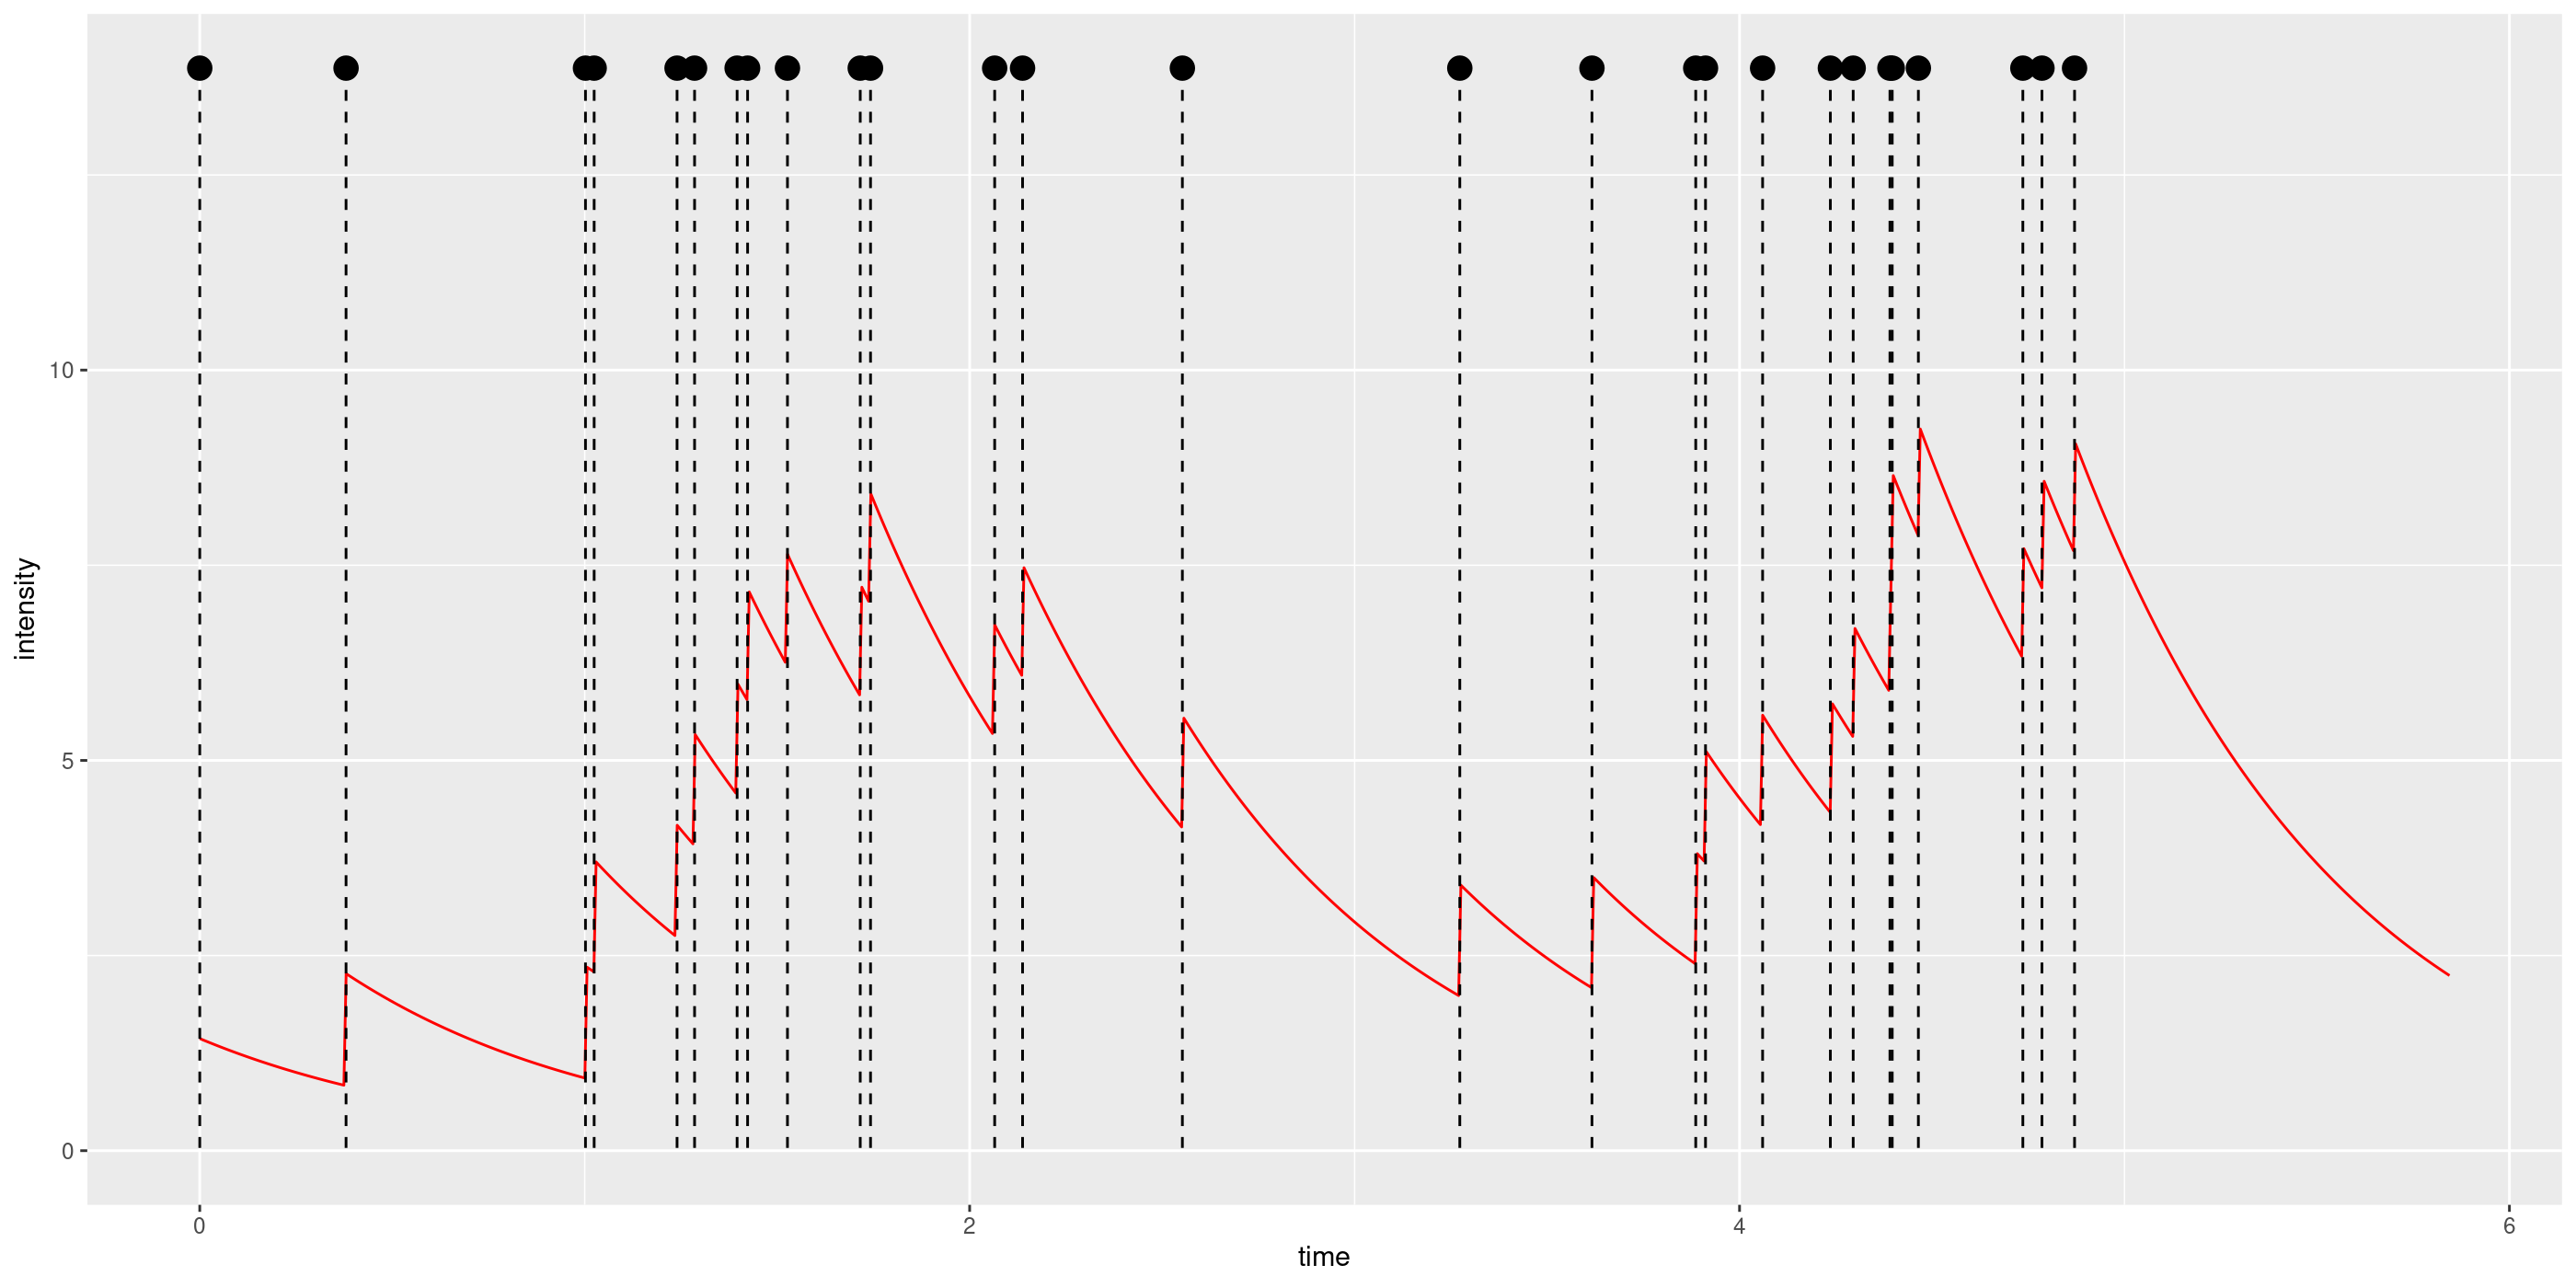

In [1034]:
library(repr)
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 200)
plot_event_series(fitted_model)

## Predykcja końcowej liczby zdarzeń w serii

Jedną z kluczowych wartości opisującą proces Hawkesa jest współczynnik rozgałęzienia, który opisuje oczekiwaną liczbę zdarzeń wygenerowanych przez pojedyncze zdarzenie. Współczynnik rozgałęzienia jest zdefiniowany w następujący sposób:

$$ n^* = \int_{0}^{\infty} \phi(\tau) \,d\tau $$

Jeżeli $n^*<1$ mówimy, że proces znajduje się w reżimie podkrytycznym, a liczba wszystkich zdarzeń w serii jest ograniczona. jeżeli $n^*>1$ proces znajduje się w reżimie superkrytycznym z rosnącą funkcją intensywności $\lambda(t)$, przez co całkowita liczba zdarzeń jest nieograniczona.

W oparciu o współczynnik rozgałęzienia możemy przewidzieć oczekiwaną liczbę zdarzeń w serii:
$$ N_\infty = \frac{1}{1-n^*} \text{, gdzie } n^*<1 $$

Spróbujmy przewidzieć wielkość kaskady zdarzeń z Twittera. Dane zawierają dwie kolumny:
- magnitude - oznaczające liczbę osób obserwujących danego użytkownika
- time - czas względem pierwszego zdarzenia

Pierwsze zdarzenie jest postem, który zapoczątkował kaskadę zdarzeń, a wszystkie kolejne zdarzenia są retweetami pierwszego.

In [24]:
library(dplyr)

history <- read.csv(file = 'hawkes_example.csv', header = T)
history <- history %>% select(-X)
head(history)

,magnitude,time
,<int>,<int>
1,40989,0
2,1445,21
3,563,31
4,329,33
5,555,49
6,513,54


Podzielmy serię na zbiór treningowy i testowy. Zdarzenia z pierwszych 50 minut posłużą jako zbiór treningowy do dopasowania parametrów procesu Hawkesa. Pozostałe zdarzenia będą użyte jako zbiór testowy do ewaluacji.

In [15]:
train_history <- history[with(history, time <= 3000),]

Dopasowujemy parametry procesu Hawkesa na podstawie zbioru treningowego:

In [36]:
fitted_model <- fit_series(train_history, model_type = 'mEXP', observation_time = max(train_history$time))
fitted_model

- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 6.78e+00; beta 8.26e-01; theta 5.40e-01
- par:
  K 3.02e-01; beta 1.90e-01; theta 9.23e-03
- Neg Log Likelihood: 539.386 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 

Sprawdźmy czy współczynnik rozgałęzienia $n^* < 1$ co umożliwi obliczenie wielkości kaskady.

In [17]:
get_branching_factor(fitted_model)

[1] 0.3716334

Obliczmy końcową wielkość kaskady zdarzeń:

In [18]:
predict_final_popularity(fitted_model)

[1] 159.9818

Przewidziana liczba zdarzeń 160 jest bliska rzeczywistej 219.

Błąd względny wynosi:

In [26]:
sprintf("%0.2f%%", 100*abs(219-160)/219)

[1] "26.94%"

## Neural Hawkes Process
Ciekawym rozwinięciem koncepcji przedstawionego tutaj procesu Hawkesa jest [neuronowy proces Hawkesa](https://proceedings.neurips.cc/paper/2017/hash/6463c88460bd63bbe256e495c63aa40b-Abstract.html), który zastępuje funkcję kernela siecią neuronową, dzięki czemu uzyskujemy większą ekspresyjność modelu, ale tracimy interpretowalność. W literaturze można również znaleźć [Transformer Hawkes Process](https://proceedings.mlr.press/v119/zuo20a.html), który implementuje mechanizm uwagi.

## Rekomendowana literatura:
[Rizoiu, Marian-Andrei, et al. "A tutorial on hawkes processes for events in social media." arXiv preprint arXiv:1708.06401 (2017).](https://arxiv.org/abs/1708.06401)